In [2]:
import pandas as pd
import numpy as np

import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point
import geoplot.crs as gcrs

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import re
from user_agents import parse

Let us load the tanishq_products.csv and tanishq_event_data.csv into DataFrames

In [3]:
event_df = pd.read_csv('/opt/cs145442/data/yfret/tanishq_event_data.csv')
product_df = pd.read_csv('/opt/cs145442/data/yfret/tanishq_products.csv')

/Users/amitkumarkhetan/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Let's take a peek at Events Dataframe

In [4]:
event_df.head(3)

,action_type,user_type,epoch,object_id,user_id,sid,og_url,tt_id,sub_account,utm_source,utm_campaign,utm_medium,referrer,utm_content,latitude,longitude,useragent,variant_id
0,view,guest,2019-11-28 20:59:00.000,Buy Engagement Rings Online - Shop Diamond Eng...,NaN,0.693364,https://www.tanishq.co.in/shop/engagement-ring...,1574974426476,tanishq,NaN,NaN,NaN,NaN,NaN,26.9167,75.8167,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN
1,view,guest,2019-11-28 20:59:00.000,500064ONAABB09,NaN,0.472003,https://www.tanishq.co.in/product/tanishq-18kt...,1574973022537,tanishq,NaN,NaN,NaN,NaN,NaN,13.0843,80.2805,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,3IH000030
2,view,guest,2019-11-28 20:59:01.000,Buy Diamond Earrings Online in India | Shop La...,NaN,0.897467,https://www.tanishq.co.in/shop/diamond-earring...,1574974640117,tanishq,NaN,NaN,NaN,NaN,NaN,38.9841,-77.3672,Mozilla/5.0 (iPhone; CPU iPhone OS 13_1_3 like...,NaN


* **action_type** is what the user is doing in that current timestamp
* **user_type** is whether is anonymous or logged in
* **epoch** is the timestamp
* **object id** is changes based on the action type Ex. product Id, collection Id etc
  * 17 NaN, will figure out the way to fill this  
* **user_id** is supposed to be user_id, whereas tt_id is also user_id
  * confusing as of now
  * 795511 NaN
* **s_id** is what the session id for which event was recorded
  * no NaN
* **og_url** is what the url for which the event was recorded
  * permalinks will be helpful for further clustering, if needed
* **tt_id** is the assumed to be unique user_id for every individual
  * no NaN
* **sub_account** is 'tanishq' for all the records, will drop this column
* **utm_params** 
  * **utm_source** 763136 NaN
  * **utm_medium** 608639 NaN
  * **utm_campaign** 608639 NaN
  * **utm_content** 797840 NaN
* **referrer** 441725 NaN
* **useragent** is the details of device and clients, we'll break it down
* **variant_id** 474166 NaN, 4831 Unique Variants

In [5]:
# list of major utm_content
# event_df['utm_content'].value_counts().iloc[0:5]

In [6]:
# list of major referrer
# event_df['referrer'].value_counts().sort_values(ascending=False).iloc[0:15]

In [7]:
# Dropping the sub_account
event_df.drop('sub_account', axis=1, inplace=True)

In [8]:
# Converting the epoch to datetime
event_df['epoch'] = pd.to_datetime(event_df['epoch'])

In [9]:
# Dropping the user_id column, tt_id has the user_id records
event_df.drop('user_id', axis=1, inplace=True)

In [10]:
# Extracting valuable informations from the og_url
event_df['og_meta'] = event_df['og_url'].apply(lambda x: ','.join(x.replace('https://www.tanishq.co.in/', '').replace('/', ',').replace('?', ',').replace('&', ',').split(',')))

In [11]:
# Adding two columns to store information such as page_details & product_details

# Page details: ['shop', 'product', 'cart', 'checkout', 'myaccount']
event_df['og_meta_page'] = event_df['og_meta'].apply(lambda x: x.split(',')[0])

# Product details: jewellery, gold-earring, etc.
event_df['og_meta_product'] = event_df['og_meta'].apply(lambda x: x.split(',')[1])

In [12]:
# tt_id of user's who placed order
user_placed_order = event_df[event_df.action_type == 'place_order']['tt_id'].tolist()

In [13]:
# sid of user's who placed order
sid_placed_order = event_df[event_df.action_type == 'place_order']['sid'].tolist()

In [14]:
# Time difference between when user starts viewing and ends up placing the order, for all their sessions
event_df[event_df['tt_id'].isin(user_placed_order)].sort_values(by='epoch', ascending=True).groupby(['tt_id', 'sid']).agg({'epoch': [np.max, np.min]})

epoch                    
                                      amax                amin
tt_id         sid                                             
1556192230670 0.240012 2019-11-30 04:58:54 2019-11-28 07:38:46
              0.255956 2019-11-30 04:56:42 2019-11-30 04:51:46
              0.479870 2019-11-30 05:37:16 2019-11-30 05:37:16
1556635697710 0.814909 2019-11-27 15:53:19 2019-11-27 10:07:41
1556696450282 0.249243 2019-11-28 17:57:23 2019-11-28 17:00:39
...                                    ...                 ...
1575124299742 0.310904 2019-11-30 14:33:50 2019-11-30 14:31:43
1575124390712 0.470990 2019-11-30 15:30:02 2019-11-30 14:35:13
1575124500709 0.194445 2019-11-30 14:38:20 2019-11-30 14:35:06
1575124764298 0.414040 2019-11-30 14:41:48 2019-11-30 14:39:39
1575137133986 0.650561 2019-11-30 18:44:38 2019-11-30 18:07:47

[163 rows x 2 columns]

In [15]:
# Time difference between when user starts viewing and ends up placing the order, for only the sessions when they placed the order
event_df_placed_order = event_df[event_df['tt_id'].isin(user_placed_order)]
event_df_placed_order_sess = event_df_placed_order[event_df_placed_order['sid'].isin(sid_placed_order)].sort_values(by='epoch', ascending=True).groupby(['tt_id', 'sid']).agg({'epoch': [np.max, np.min]}).add_suffix('_time').reset_index()
event_df_placed_order_sess['diff_time'] = event_df_placed_order_sess[('epoch_time', 'amax_time')] - event_df_placed_order_sess[('epoch_time', 'amin_time')]
event_df_placed_order_sess.drop([('epoch_time', 'amax_time'), ('epoch_time', 'amin_time')], inplace=True, axis=1)
event_df_placed_order_sess.sort_values(by='diff_time')

,tt_id,sid,diff_time
,,,
0,1556192230670,0.479870,0 days 00:00:00
81,1574934398996,0.007747,0 days 00:00:00
51,1574512367068,0.989481,0 days 00:00:00
101,1575120855672,0.903357,0 days 00:01:29
103,1575123943054,0.381226,0 days 00:01:41
...,...,...,...
55,1574750715471,0.181861,2 days 23:36:59
12,1562961302380,0.062601,3 days 00:26:36
68,1574848138072,0.207920,3 days 00:45:27


In [16]:
# Looking at the user activity for the tt_id '1575137133986'
event_df[event_df['tt_id'].isin([1575137133986])].sort_values(by='epoch', ascending=True)

,action_type,user_type,epoch,object_id,sid,og_url,tt_id,utm_source,utm_campaign,utm_medium,referrer,utm_content,latitude,longitude,useragent,variant_id,og_meta,og_meta_page,og_meta_product
781852,view,guest,2019-11-30 18:07:47,Buy Platinum Pendant Online | Platinum Pendant...,0.650561,https://www.tanishq.co.in/shop/platinum-pendants,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,"shop,platinum-pendants",shop,platinum-pendants
782415,view,guest,2019-11-30 18:09:02,Buy Gold,0.650561,https://www.tanishq.co.in/shop/jewellery?sort=...,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,"shop,jewellery,sort=10,page=3",shop,jewellery
782497,view,guest,2019-11-30 18:09:33,Buy Gold,0.650561,https://www.tanishq.co.in/shop/jewellery?sort=...,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,"shop,jewellery,sort=10,page=4",shop,jewellery
782560,view,guest,2019-11-30 18:09:53,Buy Gold,0.650561,https://www.tanishq.co.in/shop/jewellery?sort=...,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,"shop,jewellery,sort=10,page=5",shop,jewellery
782846,view,guest,2019-11-30 18:10:21,Buy Gold,0.650561,https://www.tanishq.co.in/shop/jewellery?sort=...,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,"shop,jewellery,sort=10,page=6",shop,jewellery
782962,view,guest,2019-11-30 18:10:58,Buy Gold,0.650561,https://www.tanishq.co.in/shop/jewellery?sort=...,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,"shop,jewellery,sort=10,page=7",shop,jewellery
783045,view,guest,2019-11-30 18:11:30,Buy Gold,0.650561,https://www.tanishq.co.in/shop/jewellery?sort=...,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,"shop,jewellery,sort=10,page=8",shop,jewellery
783128,view,guest,2019-11-30 18:11:58,501718FENLAA29,0.650561,https://www.tanishq.co.in/product/tanishq-18kt...,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2JA000075,"product,tanishq-18kt-rose-gold-ruby-and-diamon...",product,tanishq-18kt-rose-gold-ruby-and-diamond-finger...
783456,view,guest,2019-11-30 18:12:50,Buy Gold,0.650561,https://www.tanishq.co.in/shop/jewellery?sort=...,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,"shop,jewellery,sort=10,page=9",shop,jewellery
784065,view,guest,2019-11-30 18:13:32,Buy Gold,0.650561,https://www.tanishq.co.in/shop/jewellery/price...,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,"shop,jewellery,price=10000-20000,gender=women,...",shop,jewellery


In [17]:
event_df['og_url_parse'] = event_df['og_url'].apply(lambda x: x.replace('https://www.tanishq.co.in', ''))

In [18]:
event_df['action_type'].unique()

array(['view', 'add_to_cart', 'remove_from_cart', 'add_to_wishlist',
       'place_order', 'remove_from_wishlist', 'register'], dtype=object)

In [19]:
event_df.loc[event_df['action_type'] == 'add_to_cart']

,action_type,user_type,epoch,object_id,sid,og_url,tt_id,utm_source,utm_campaign,utm_medium,referrer,utm_content,latitude,longitude,useragent,variant_id,og_meta,og_meta_page,og_meta_product,og_url_parse
68,add_to_cart,guest,2019-11-28 21:00:21,500357SBAABA02,0.526388,https://www.tanishq.co.in/shop/earrings/jewell...,1574973309185,NaN,NaN,NaN,NaN,NaN,43.6665,-79.8054,Mozilla/5.0 (iPad; CPU OS 12_4_1 like Mac OS X...,3IA000099,"shop,earrings,jewellery-type=diamond-jewellery...",shop,earrings,/shop/earrings/jewellery-type=diamond-jeweller...
125,add_to_cart,guest,2019-11-28 21:01:47,500925SIAABA09,0.526388,https://www.tanishq.co.in/shop/earrings/jewell...,1574973309185,NaN,NaN,NaN,NaN,NaN,43.6665,-79.8054,Mozilla/5.0 (iPad; CPU OS 12_4_1 like Mac OS X...,2JA005187,"shop,earrings,jewellery-type=diamond-jewellery...",shop,earrings,/shop/earrings/jewellery-type=diamond-jeweller...
303,add_to_cart,guest,2019-11-28 00:46:31,5003431SAABA32,0.160013,https://www.tanishq.co.in/product/tanishq-18kt...,1574901964247,NaN,Sok_Traffic_MultipleAds_Prospecting_Tanishq_No...,cpc,m.facebook.com,NaN,14.6833,77.6000,Mozilla/5.0 (Linux; Android 9; AMN-LX2) AppleW...,2JA000701,"product,tanishq-18kt-gold-diamond-and-ruby-pen...",product,tanishq-18kt-gold-diamond-and-ruby-pendant-ear...,/product/tanishq-18kt-gold-diamond-and-ruby-pe...
887,add_to_cart,guest,2019-11-28 21:02:58,511518FAVRAA00,0.433965,https://www.tanishq.co.in/shop/gold-finger-rin...,1574974571343,NaN,NaN,NaN,NaN,NaN,42.3498,-71.0765,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2EA005704,"shop,gold-finger-rings,gender=men,gold-karatag...",shop,gold-finger-rings,/shop/gold-finger-rings/gender=men&gold-karata...
909,add_to_cart,guest,2019-11-28 21:03:16,511518FARRAA00,0.433965,https://www.tanishq.co.in/shop/gold-finger-rin...,1574974571343,NaN,NaN,NaN,NaN,NaN,42.3498,-71.0765,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2EA005592,"shop,gold-finger-rings,gender=men,gold-karatag...",shop,gold-finger-rings,/shop/gold-finger-rings/gender=men&gold-karata...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800655,add_to_cart,guest,2019-11-29 14:52:53,51T340FAIDAA00,0.560385,https://www.tanishq.co.in/product/tanishq-22kt...,1558291156074,NaN,NaN,NaN,NaN,NaN,26.1833,91.7333,Mozilla/5.0 (iPhone; CPU iPhone OS 12_4 like M...,2JA005340,"product,tanishq-22kt-gold-finger-ring-with-geo...",product,tanishq-22kt-gold-finger-ring-with-geometric-e...,/product/tanishq-22kt-gold-finger-ring-with-ge...
800688,add_to_cart,guest,2019-11-29 14:53:06,513217VFCR1AP1,0.753222,https://www.tanishq.co.in/product/tanishq-22kt...,1575038131822,NaN,NaN,NaN,NaN,NaN,22.5720,88.3670,Mozilla/5.0 (Linux; Android 4.4.4; 2014818) Ap...,2EA005353,"product,tanishq-22kt-gold-bangle-513217vfc1ap1",product,tanishq-22kt-gold-bangle-513217vfc1ap1,/product/tanishq-22kt-gold-bangle-513217vfc1ap1
801093,add_to_cart,guest,2019-11-29 14:55:41,502998SABAAA09,0.026731,https://www.tanishq.co.in/product/tanishq-18kt...,1575038362765,NaN,NaN,NaN,NaN,NaN,26.1833,91.7333,Mozilla/5.0 (Linux; Android 9; SAMSUNG SM-G960...,2JA005225,"product,tanishq-18kt-gold-and-diamond-stud-ear...",product,tanishq-18kt-gold-and-diamond-stud-earrings-50...,/product/tanishq-18kt-gold-and-diamond-stud-ea...
801292,add_to_cart,guest,2019-11-29 14:56:48,552818BADYAA37,0.142335,https://www.tanishq.co.in/product/bracelet-552...,1571382082076,NaN,NaN,NaN,NaN,NaN,18.9721,72.8246,Mozilla/5.0 (iPhone; CPU iPhone OS 13_1 like M...,2JA005371,"product,bracelet-552818badaa37",product,bracelet-552818badaa37,/product/bracelet-552818badaa37


## Geographical distribution of users who browsed

In [20]:
collision_points = event_df.apply(
    lambda srs: Point(float(srs['longitude']), float(srs['latitude'])),
    axis='columns'
)

collision_points[0:2]

0    POINT (75.8167 26.9167)
1    POINT (80.2805 13.0843)
dtype: object

In [21]:
data_geocoded = gpd.GeoDataFrame(event_df, geometry=collision_points)

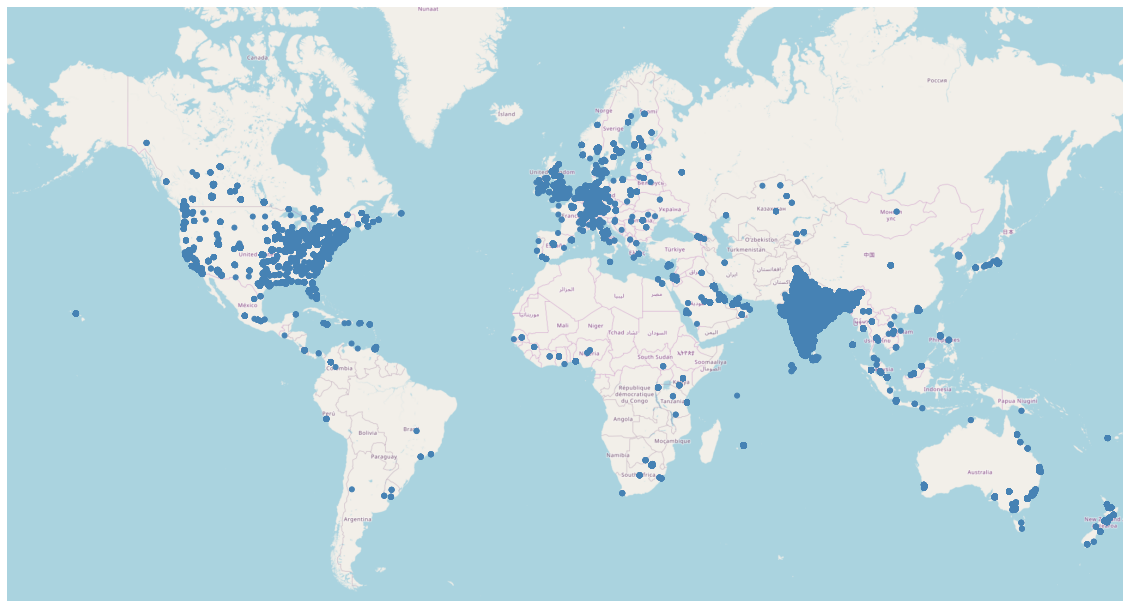

In [22]:
ax = gplt.webmap(data_geocoded, projection=gcrs.WebMercator(), figsize=(20,15))
gplt.pointplot(data_geocoded, ax=ax)

## Geographical distribution of users who added to cart

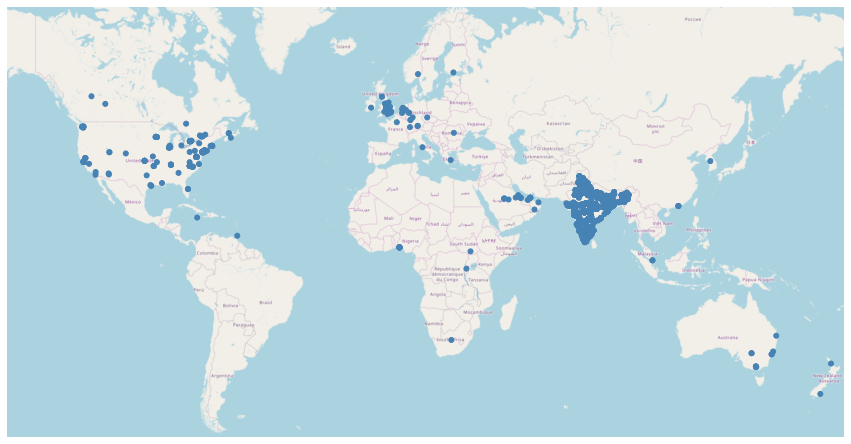

In [23]:
ax2 = gplt.webmap(data_geocoded[data_geocoded.action_type == 'add_to_cart'], projection=gcrs.WebMercator(), figsize=(15,30))
gplt.pointplot(data_geocoded[data_geocoded.action_type == 'add_to_cart'], ax=ax2)

## Geographical distribution of users who placed order

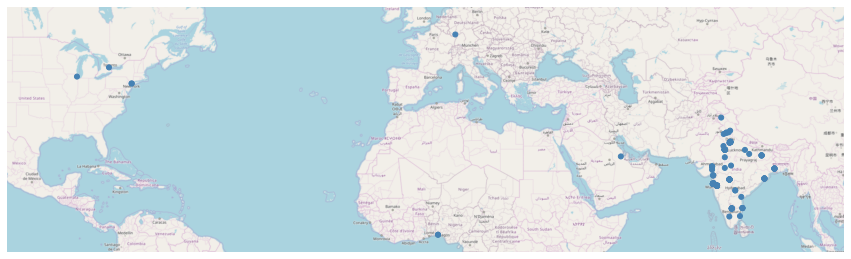

In [24]:
ax3 = gplt.webmap(data_geocoded[data_geocoded.action_type == 'place_order'], projection=gcrs.WebMercator(), figsize=(15,30))
gplt.pointplot(data_geocoded[data_geocoded.action_type == 'place_order'], ax=ax3)

  * Out of **139** user's who placed order, __133 were from INDIA__

## Analysis of UTM Parameters of users who placed order

In [25]:
data_placed_order = event_df[event_df.action_type == 'place_order']

In [26]:
print(data_placed_order['utm_source'].value_counts())
print(data_placed_order['utm_medium'].value_counts())
print(data_placed_order['utm_campaign'].value_counts())

Series([], Name: utm_source, dtype: int64)
Series([], Name: utm_medium, dtype: int64)
Series([], Name: utm_campaign, dtype: int64)


  * Users who placed the order had **NO UTM Parameters**

In [27]:
# What is the hypothesis?
# Goal is to find the list of buyers who came from which utm_source
event_df[event_df['sid'].isin(data_placed_order['sid'].tolist())].groupby('tt_id').action_type.value_counts()

tt_id          action_type     
1556192230670  place_order          1
1556635697710  view                10
               add_to_cart          2
               place_order          1
1556696450282  view                21
                                   ..
1575124764298  view                 1
1575137133986  view                26
               add_to_cart          1
               place_order          1
               remove_from_cart     1
Name: action_type, Length: 331, dtype: int64

In [28]:
event_df[event_df['sid'].isin(data_placed_order['sid'].tolist())]['utm_source'].value_counts()

yfret        29
criteo       11
FBTanishq     8
Name: utm_source, dtype: int64

## Analysis of daily users actions statistics

In [29]:
# Will convert the epoch to epoch_date
event_df['epoch_date'] = event_df['epoch'].dt.date

In [30]:
daily_action_df = event_df.sort_values(by='epoch_date').groupby(['epoch_date', 'action_type']).agg({'action_type': 'count'}).add_suffix('_count').reset_index()

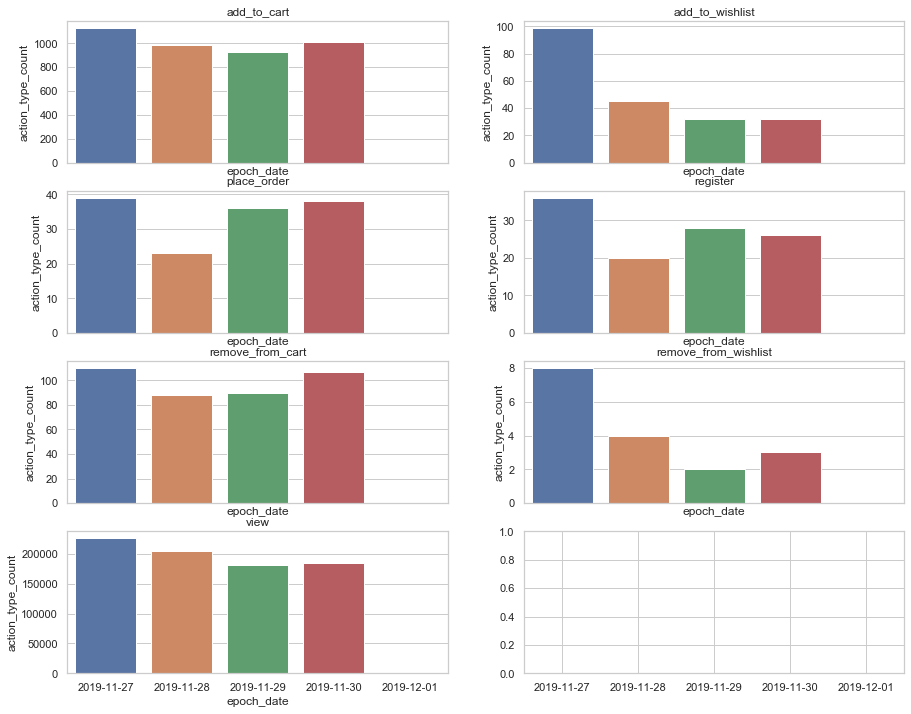

In [31]:
f, axes = plt.subplots(4, 2, figsize=(15, 12), sharex=True)
action_type = daily_action_df.action_type.unique().tolist()
axes[0, 0].set(title=action_type[0])
axes[0, 1].set(title=action_type[1])
axes[1, 0].set(title=action_type[2])
axes[1, 1].set(title=action_type[3])
axes[2, 0].set(title=action_type[4])
axes[2, 1].set(title=action_type[5])
axes[3, 0].set(title=action_type[6])
sns.barplot(data=daily_action_df[daily_action_df.action_type == action_type[0]], x='epoch_date', y='action_type_count', ax=axes[0, 0], label=action_type[0])
sns.barplot(data=daily_action_df[daily_action_df.action_type == action_type[1]], x='epoch_date', y='action_type_count', ax=axes[0, 1], label=action_type[1])
sns.barplot(data=daily_action_df[daily_action_df.action_type == action_type[2]], x='epoch_date', y='action_type_count', ax=axes[1, 0], label=action_type[2])
sns.barplot(data=daily_action_df[daily_action_df.action_type == action_type[3]], x='epoch_date', y='action_type_count', ax=axes[1, 1], label=action_type[3])
sns.barplot(data=daily_action_df[daily_action_df.action_type == action_type[4]], x='epoch_date', y='action_type_count', ax=axes[2, 0], label=action_type[4])
sns.barplot(data=daily_action_df[daily_action_df.action_type == action_type[5]], x='epoch_date', y='action_type_count', ax=axes[2, 1], label=action_type[5])
sns.barplot(data=daily_action_df[daily_action_df.action_type == action_type[6]], x='epoch_date', y='action_type_count', ax=axes[3, 0], label=action_type[6])

## What's important in a piece of jewellery for you?

In [32]:
# How many users who placed orders?
len(user_placed_order)

136

In [33]:
event_df.columns

Index(['action_type', 'user_type', 'epoch', 'object_id', 'sid', 'og_url',
       'tt_id', 'utm_source', 'utm_campaign', 'utm_medium', 'referrer',
       'utm_content', 'latitude', 'longitude', 'useragent', 'variant_id',
       'og_meta', 'og_meta_page', 'og_meta_product', 'og_url_parse',
       'geometry', 'epoch_date'],
      dtype='object')

In [34]:
# Let's create a dataFrame with user_id, og_meta_products_sum, utm_source, user_agent_browser, user_agent_os
data = list()
for user in user_placed_order:
    user_details = list()
    
    user_details.append(user)
    usl = event_df[event_df.tt_id == user].utm_source.dropna().unique().tolist()
    user_details.append(usl if len(usl) > 0 else 'NA')

    ua = event_df[event_df.tt_id == user].loc[event_df['action_type'] == 'place_order']['useragent'].unique().tolist()
    user_details.append(len(ua))
    
    user_agent = parse(ua[0])
    user_details.append(user_agent.os.family)
    user_details.append(user_agent.browser.family)

    og_meta_product_sum = event_df[event_df.tt_id == user].og_meta_product.dropna().tolist()
    user_details.append(og_meta_product_sum)
    
    user_agent = parse(ua[0])

    data.append(user_details)
user_df = pd.DataFrame(data, columns=['user_id', 'utm_source', 'placed_order_count', 'user_agent_os', 'user_agent_browser', 'og_meta_view'])
user_df.head()

,user_id,utm_source,placed_order_count,user_agent_os,user_agent_browser,og_meta_view
0,1569375830630,NA,1,Android,Facebook,"[confirmation, pair-of-bangles-in-22kt-yellow-..."
1,1572467136437,NA,1,Android,Chrome Mobile WebView,[10-gm-24kt-gold-coin-with-tanishq-logo-600102...
2,1574820583771,NA,1,iOS,Mobile Safari,"[confirmation, confirmation, gold-pendants, go..."
3,1574820583771,NA,1,iOS,Mobile Safari,"[confirmation, confirmation, gold-pendants, go..."
4,1570708601141,NA,1,Android,Facebook,"[confirmation, tanishq-22kt-gold-chain-for-wom..."


In [35]:
# Parsing useragent metadata
event_df['useragent'] = event_df['useragent'].fillna('ffill')
event_df['user_agent_os'] = event_df['useragent'].apply(lambda x: parse(x).os.family)
event_df['user_agent_browser'] = event_df['useragent'].apply(lambda x: parse(x).browser.family)

In [36]:
# Drop the useragent col
event_df.drop('useragent', axis=1, inplace=True)

## Taking a peek at product catalog data

In [37]:
product_df.columns
# After dropping irrelevant columns

Index(['_id', 'additional_image', 'adult', 'availability_date', 'avlble',
       'brand', 'business_unit', 'category', 'collection', 'color',
       'condition', 'created_on', 'currency', 'currency_symbol', 'description',
       'diamond_clarity', 'diamond_color', 'diamond_cut',
       'discount_percentage', 'expiration_date', 'full_description',
       'gemstone1', 'gemstone2', 'gemstone3', 'gemstone4', 'gemstone5',
       'gender', 'goldkaratage', 'google_product_category', 'gtin', 'height',
       'id', 'identifier_exists', 'image', 'item_group_id', 'jew_size',
       'jewellery_type', 'last_modified_on', 'listprice', 'metal',
       'metal_color', 'mfr_code', 'mpn', 'name', 'occasion', 'out_of_shelf',
       'price', 'price_usd', 'product', 'product_type', 'sale_price_usd',
       'status', 'sub_account', 'subcategories', 'trendrank', 'unit',
       'updated', 'url', 'variants', 'width'],
      dtype='object')

In [38]:
product_df.drop('color', axis=1, inplace=True) # No data
product_df.drop('adult', axis=1, inplace=True) # No relevant data
product_df.drop('condition', axis=1, inplace=True) # All are new
product_df.drop('currency', axis=1, inplace=True) # All are INR
product_df.drop('currency_symbol', axis=1, inplace=True) # All are INR
product_df.drop('availability_date', axis=1, inplace=True) # Not Relevant
product_df.drop('business_unit', axis=1, inplace=True) # All are Jewellery
product_df.drop('expiration_date', axis=1, inplace=True) # No Data
product_df.drop('gtin', axis=1, inplace=True) # No Data
product_df.drop('status', axis=1, inplace=True) # All are Active
product_df.drop('identifier_exists', axis=1, inplace=True) # All are False
product_df.drop('updated', axis=1, inplace=True) # All are False

In [39]:
product_df.loc[product_df.mfr_code == '600102ZNARAS00']

,_id,additional_image,avlble,brand,category,collection,created_on,description,diamond_clarity,diamond_color,...,product,product_type,sale_price_usd,sub_account,subcategories,trendrank,unit,url,variants,width
3303,3.360280e+38,https://staticimg.titan.co.in/Tanishq/Catalog/...,1,Tanishq,NaN,NaN,1.573540e+12,1 gm 24KT Gold Coin with Tanishq Logo,NaN,NaN,...,COINS,Home > Jeweller,66.03,[tanishq],Jeweller,1.0,NaN,/product/1-gm-24kt-gold-coin-with-tanishq-logo...,"{u'': {u'price': 4707.0, u'listprice': 4707.0}}",NaN


### How many unique visitors?

In [40]:
len(event_df['tt_id'].unique().tolist())

179168

## Analysing most popular *products* & *brands* in the catalog
### Based on User's Actions i.e,
1. View
2. Add to Cart
3. Place Order

In [41]:
objects_viewed = event_df[event_df['action_type'] == 'view']['object_id'].value_counts()
product_viewed_dict = dict()
brands_viewed_dict = dict()
for k, v in objects_viewed.items():
    try:
        product_viewed_dict[product_df.loc[product_df.mfr_code == k]['product'].values[0]] = product_viewed_dict.get(product_df.loc[product_df.mfr_code == k]['product'].values[0], 0) + v
    except:
        pass
    try:
        brands_viewed_dict[product_df.loc[product_df.mfr_code == k]['brand'].values[0]] = brands_viewed_dict.get(product_df.loc[product_df.mfr_code == k]['brand'].values[0], 0) + 1
    except:
        pass

In [42]:
objects_added_to_cart = event_df[event_df['action_type'] == 'add_to_cart']['object_id'].value_counts()
product_added_to_cart_dict = dict()
brands_added_to_cart_dict = dict()
for k, v in objects_added_to_cart.items():
    product_added_to_cart_dict[product_df.loc[product_df.mfr_code == k]['product'].values[0]] = product_added_to_cart_dict.get(product_df.loc[product_df.mfr_code == k]['product'].values[0], 0) + v
    try:
        brands_added_to_cart_dict[product_df.loc[product_df.mfr_code == k]['brand'].values[0]] = brands_added_to_cart_dict.get(product_df.loc[product_df.mfr_code == k]['brand'].values[0], 0) + 1
    except:
        pass

In [43]:
objects_placed_order = event_df[event_df['action_type'] == 'place_order']['object_id'].value_counts()
product_placed_order_dict = dict()
brands_placed_order_dict = dict()
for k, v in objects_placed_order.items():
    product_placed_order_dict[product_df.loc[product_df.mfr_code == k]['product'].values[0]] = product_placed_order_dict.get(product_df.loc[product_df.mfr_code == k]['product'].values[0], 0) + v
    try:
        brands_placed_order_dict[product_df.loc[product_df.mfr_code == k]['brand'].values[0]] = brands_placed_order_dict.get(product_df.loc[product_df.mfr_code == k]['brand'].values[0], 0) + 1
    except:
        pass

*Preprocessing for Plotting*

In [44]:
product_action_type_view_df = pd.DataFrame.from_dict(product_viewed_dict, orient='index', columns=['view_count'])
product_action_type_added_to_cart_df = pd.DataFrame.from_dict(product_added_to_cart_dict, orient='index', columns=['add_to_cart_count'])
product_action_type_placed_order_df = pd.DataFrame.from_dict(product_placed_order_dict, orient='index', columns=['place_order_count'])
product_action_type_df = pd.concat([product_action_type_view_df, product_action_type_added_to_cart_df, product_action_type_placed_order_df], axis=1).reset_index().rename(columns={'index': 'product'}).fillna(0)

In [45]:
brands_viewed_df = pd.DataFrame.from_dict(brands_viewed_dict, orient='index', columns=['view_count'])
brands_added_to_cart_df = pd.DataFrame.from_dict(brands_added_to_cart_dict, orient='index', columns=['add_to_cart_count'])
brands_placed_order_df = pd.DataFrame.from_dict(brands_placed_order_dict, orient='index', columns=['place_order_count'])
brands_action_type_df = pd.concat([brands_viewed_df, brands_added_to_cart_df, brands_placed_order_df], axis=1).reset_index().rename(columns={'index': 'brand'}).fillna(0)

*Plotting for Catgory of Products v/s Action Type*

[]

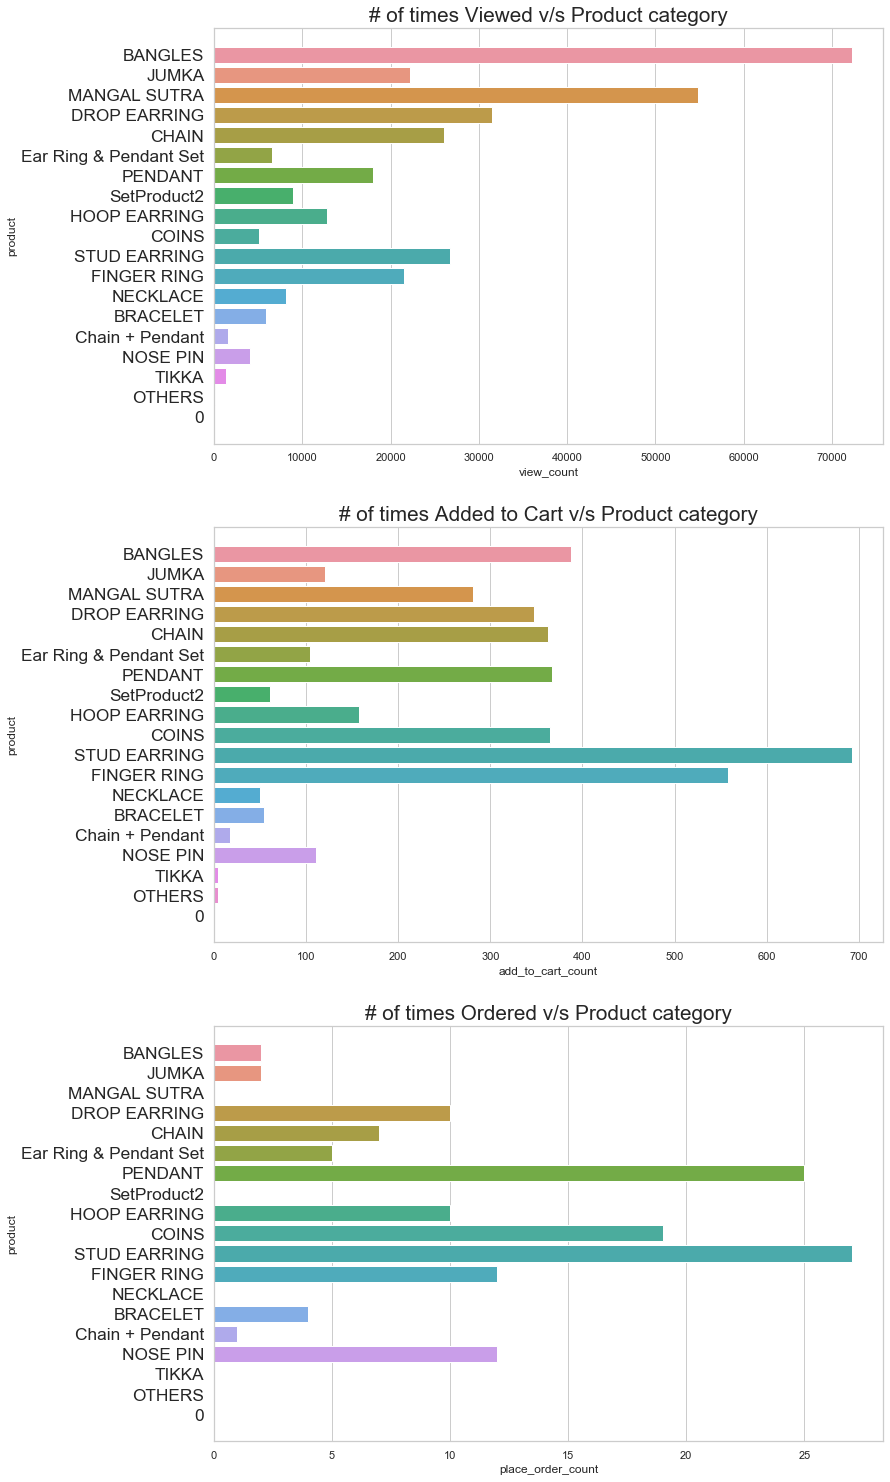

In [46]:
fig, ax = plt.subplots(3, 1, figsize=(12,26))

chart_v = sns.barplot(y="product", x="view_count", data=product_action_type_df, ax=ax[0])
chart_atc = sns.barplot(y="product", x="add_to_cart_count", data=product_action_type_df, ax=ax[1])
chart_po = sns.barplot(y="product", x="place_order_count", data=product_action_type_df, ax=ax[2])

chart_v.set_title('# of times Viewed v/s Product category', fontsize='xx-large')
chart_atc.set_title('# of times Added to Cart v/s Product category', fontsize='xx-large')
chart_po.set_title('# of times Ordered v/s Product category', fontsize='xx-large')

chart_v.set_yticklabels(labels=chart_v.get_yticklabels(), horizontalalignment='right', fontsize='x-large')
chart_atc.set_yticklabels(labels=chart_atc.get_yticklabels(), horizontalalignment='right', fontsize='x-large')
chart_po.set_yticklabels(labels=chart_po.get_yticklabels(), horizontalalignment='right', fontsize='x-large')

# chart_v.set_xticklabels(labels=chart_v.get_xticklabels(), horizontalalignment='right', fontsize='x-large')
# chart_atc.set_xticklabels(labels=chart_atc.get_xticklabels(), horizontalalignment='right', fontsize='x-large')
# chart_po.set_xticklabels(labels=chart_po.get_xticklabels(), horizontalalignment='right', fontsize='x-large')

chart_v.plot()
chart_atc.plot()
chart_po.plot()

*Plotting for Brands of Products v/s Action Type*

[]

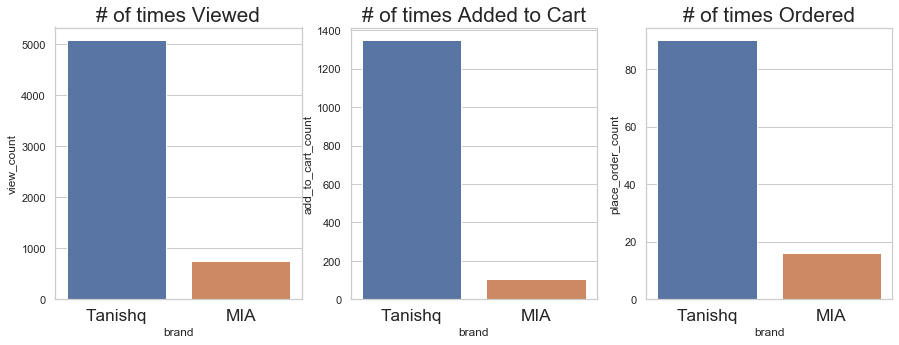

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

chart_v = sns.barplot(x="brand", y="view_count", data=brands_action_type_df, ax=ax[0])
chart_atc = sns.barplot(x="brand", y="add_to_cart_count", data=brands_action_type_df, ax=ax[1])
chart_po = sns.barplot(x="brand", y="place_order_count", data=brands_action_type_df, ax=ax[2])

chart_v.set_title('# of times Viewed', fontsize='xx-large')
chart_atc.set_title('# of times Added to Cart', fontsize='xx-large')
chart_po.set_title('# of times Ordered', fontsize='xx-large')

# chart_v.set_yticklabels(labels=chart_v.get_yticklabels(), horizontalalignment='right', fontsize='x-large')
# chart_atc.set_yticklabels(labels=chart_atc.get_yticklabels(), horizontalalignment='right', fontsize='x-large')
# chart_po.set_yticklabels(labels=chart_po.get_yticklabels(), horizontalalignment='right', fontsize='x-large')

chart_v.set_xticklabels(labels=chart_v.get_xticklabels(), horizontalalignment='center', fontsize='x-large')
chart_atc.set_xticklabels(labels=chart_atc.get_xticklabels(), horizontalalignment='center', fontsize='x-large')
chart_po.set_xticklabels(labels=chart_po.get_xticklabels(), horizontalalignment='center', fontsize='x-large')

chart_v.plot()
chart_atc.plot()
chart_po.plot()

## User Traffic Analysis

### User's Operating System

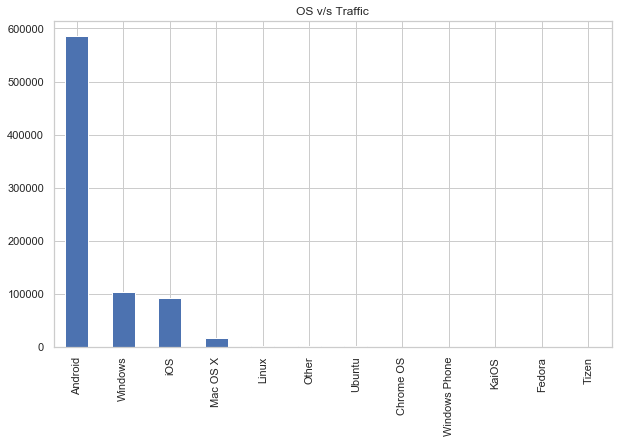

In [48]:
event_df['user_agent_os'].value_counts().plot(kind='bar', figsize=(10, 6), title="OS v/s Traffic")

### User's Browser

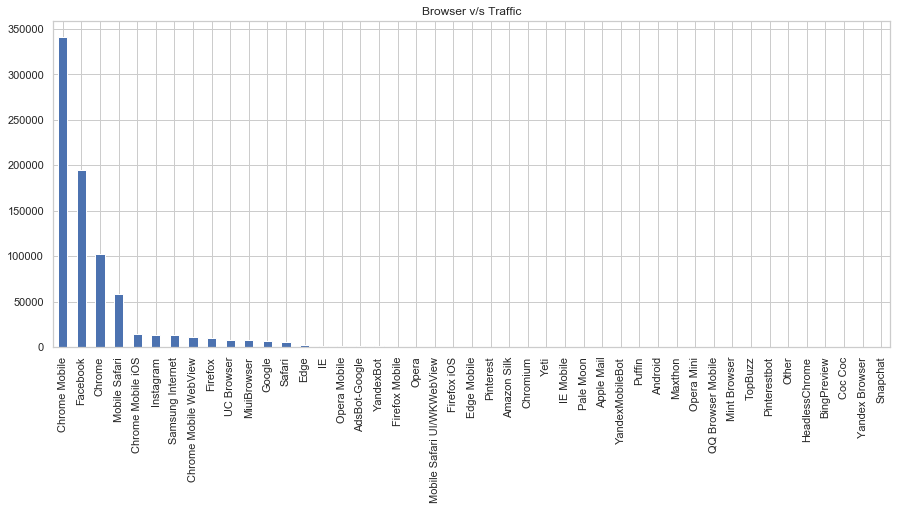

In [49]:
event_df['user_agent_browser'].value_counts().plot(kind='bar', figsize=(15, 6), title="Browser v/s Traffic")

#### Hypothesis: 
* User places order more on the bigger screen than small screen devices 

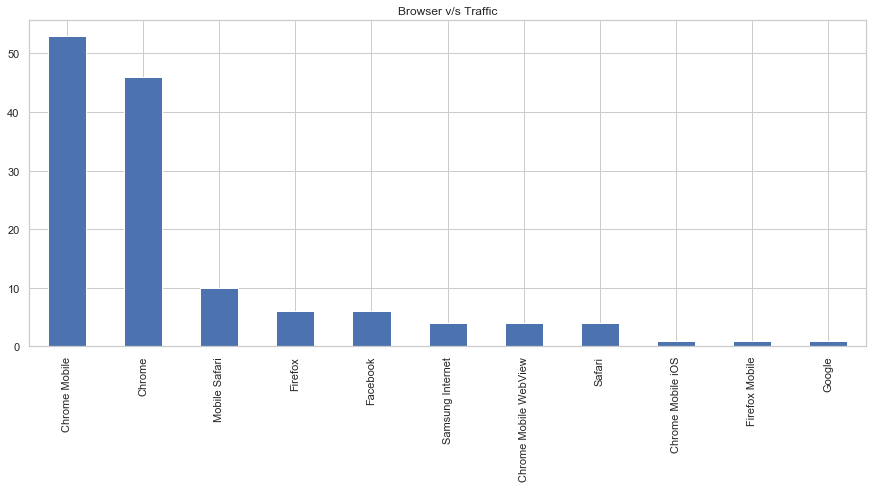

In [50]:
event_df[event_df.action_type == 'place_order']['user_agent_browser'].value_counts().plot(kind='bar', figsize=(15, 6), title="Browser v/s Traffic")

* Above analysis nullifies the hypothesis as we observe nearly equal # of order's on both mobile and desktop, on the given sample space

## What insights can we offer the visitor to guide them in their buying journey?

In [51]:
# Let's gather the user_id who actually placed order
users_placed_order = event_df[event_df['action_type'] == 'place_order']['tt_id'].unique().tolist()

In [52]:
# Now let's see the products they bought together
purchased_items = list()
for users in users_placed_order:
    purchased_items.append(list(event_df[event_df.tt_id == users].loc[event_df.action_type == 'place_order'].object_id.values))

In [53]:
purchased_items[0:5]

[['51T051VCVM2A00', '512018DJHAGA00'],
 ['600102ZBARAS00', '600102ZBARAS00', '600102ZBARAS00'],
 ['501181PMAAAA37', '501181PMAAAA37'],
 ['512313CCADAA00'],
 ['503416FDZSAA02']]

In [54]:
# Write a function that would show items that were bought together (same of different dates) by the same customer
def recommender_bought_bought(item_id, purchased_items):
    
    # Perhaps implement a binary search for that item id in the list of arrays
    # Then put the arrays containing that item id in a new list
    # Then merge all items in that list and get rid of duplicates
    recommender_list = []
    for x in purchased_items:
        if item_id in x:
            recommender_list += x
    
    # Then merge recommender list and remove the item id
    recommender_list = list(set(recommender_list) - set([item_id]))
    
#     # Print the name of the item_id and recommended items along with it
#     if len(recommender_list) > 0:
#         print(product_df[product_df['mfr_code'] == item_id]['product'].values[0], end=' -> ')
#         for item in recommender_list:
#             print(product_df[product_df['mfr_code'] == item]['product'].values[0], end=', ')
#         print('')
    
    return recommender_list

## So now we can present to the visitor a list of the other items a customer previously bought along with what item the current visitor is viewing e.g. item number '51T051VCVM2A00'

In [55]:
recommender_bought_bought('51T051VCVM2A00', purchased_items)

['512018DJHAGA00']

# Practising some Statistical Analysis

### Two-way table for user devices and whether they bought or not

In [56]:
two_way_table = pd.crosstab(index=event_df['user_agent_os'],
           columns=event_df['action_type'])
two_way_table.index = event_df['user_agent_os'].unique().tolist()
two_way_table
# event_df.groupby(['action_type', 'user_agent_os']).size()

action_type,add_to_cart,add_to_wishlist,place_order,register,remove_from_cart,remove_from_wishlist,view
Windows,2736,63,67,70,155,1,582364
iOS,2,0,0,0,0,0,561
Android,0,0,0,0,0,0,8
Mac OS X,0,0,0,0,0,0,36
Linux,16,6,2,1,0,1,2377
Other,110,28,7,2,23,6,16782
Chrome OS,0,0,0,0,0,0,1894
Tizen,0,0,0,0,0,0,1
KaiOS,2,0,0,0,0,0,760
Ubuntu,829,84,47,26,188,6,101229


In [57]:
product_df.columns

Index(['_id', 'additional_image', 'avlble', 'brand', 'category', 'collection',
       'created_on', 'description', 'diamond_clarity', 'diamond_color',
       'diamond_cut', 'discount_percentage', 'full_description', 'gemstone1',
       'gemstone2', 'gemstone3', 'gemstone4', 'gemstone5', 'gender',
       'goldkaratage', 'google_product_category', 'height', 'id', 'image',
       'item_group_id', 'jew_size', 'jewellery_type', 'last_modified_on',
       'listprice', 'metal', 'metal_color', 'mfr_code', 'mpn', 'name',
       'occasion', 'out_of_shelf', 'price', 'price_usd', 'product',
       'product_type', 'sale_price_usd', 'sub_account', 'subcategories',
       'trendrank', 'unit', 'url', 'variants', 'width'],
      dtype='object')